説明変数がアヤメの特徴量，目的変数がアヤメの種類である

$\mu=\alpha+\beta X$ \\
$\theta=\operatorname{softmax}(\mu)$ \\
$y \sim \operatorname{Cat}(\theta)$


https://www.kaggle.com/datasets/uciml/iris

またアヤメごとの個体差を考慮した階層ベイズモデルを作成し、両者の予測精度を比較する

In [ ]:
import pystan
import arviz
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

iris = pd.read_csv('input/iris-data.csv')
df=iris.replace({'target': {'setosa': 1}})
df=df.replace({'target': {'versicolor': 2}})
df=df.replace({'target': {'virginica': 3}})

In [ ]:
y = df.iloc[:,4] 
y

0      1
1      1
2      1
3      1
4      1
      ..
145    3
146    3
147    3
148    3
149    3
Name: target, Length: 150, dtype: int64

In [ ]:
x = df.iloc[:, [0,1,2,3]] 

In [ ]:
stan_data = {
    'N': x.shape[0], # データ数
    'M': x.shape[1], # 説明変数の数
    'K': 3,
    'x': x,
    'y': y
    }

stan_data

{'K': 3,
 'M': 4,
 'N': 150,
 'x':      sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
 0                  5.1               3.5                1.4               0.2
 1                  4.9               3.0                1.4               0.2
 2                  4.7               3.2                1.3               0.2
 3                  4.6               3.1                1.5               0.2
 4                  5.0               3.6                1.4               0.2
 ..                 ...               ...                ...               ...
 145                6.7               3.0                5.2               2.3
 146                6.3               2.5                5.0               1.9
 147                6.5               3.0                5.2               2.0
 148                6.2               3.4                5.4               2.3
 149                5.9               3.0                5.1               1.8
 
 [150 rows x 4 c

階層なしモデル

In [ ]:
stan_code = """
data {
  int K;
  int N; // データ数
  int M; // 変数の数
  matrix[N, M] x; // 説明変数をNxM行列の matrix で宣言 
  int y[N]; // 目的変数
}

parameters {
  matrix[M, K] beta;
}
transformed parameters {
    real p[N];
    matrix[N, K] x_beta = x * beta;
    for (i in 1:N){
      p[i] =x_beta[i][1]';
  }
}
model {
  # matrix[N, K] x_beta = x * beta;
  # to_vector(beta) ~ normal(0, 5);
  for (n in 1:N) {
    y[n] ~ categorical_logit(x_beta[n]');
  }
}
"""

In [ ]:
model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6d25361f08ccf94d5d97e972cb4c107c NOW.


In [ ]:
# MCMCの実行
fit = model.sampling(
    data = stan_data, 
    iter = 2000, 
    warmup = 1000, 
    chains = 4, 
    thin = 1, 
    seed = 1 
)

階層ありモデル

In [ ]:
stan_code = """
data {
  int K;
  int N; // データ数
  int M; // 変数の数
  matrix[N, M] x; // 説明変数をNxM行列の matrix で宣言 
  int y[N]; // 目的変数
}

parameters {
  matrix[M, K] beta;
  real bs[N];
  real<lower=0> sigma_s; // アヤメごとのばらつき
}
transformed parameters {
    real p[N];
    matrix[N, K] x_beta = x * beta;
    for (i in 1:N){
      p[i] =x_beta[i][1]';
  }
}
model {
  # matrix[N, K] x_beta = x * beta;
  # to_vector(beta) ~ normal(0, 5);
  for (s in 1:N) {
      bs[s] ~ normal(0, sigma_s);
  }
  for (n in 1:N) {
    y[n] ~ categorical_logit(x_beta[n]'+bs[n]);
  }
}
"""


In [ ]:
hierarchial_model = pystan.StanModel(model_code=stan_code)

In [ ]:
# MCMCの実行
fit2 = hierarchial_model.sampling(
    data = stan_data, 
    iter = 2000,
    warmup = 1000,
    chains = 4, 
    thin = 1, 
    seed = 1 
)

Inference for Stan model: anon_model_6d25361f08ccf94d5d97e972cb4c107c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1,1]     3427.4  3745.4 5522.7  -95.67 118.91 576.38 2457.3  1.6e4      2    4.4
beta[2,1]     887.83  486.66 2039.0   -1894 247.29 619.79 932.62 6946.4     18   1.16
beta[3,1]      -7292  7398.2  1.1e4  -3.8e4  -6779 -996.7 -337.4  36.09      2   3.47
beta[4,1]      -4328  2980.9 5306.3  -1.8e4  -4596  -2562 -434.7 -290.3      3   4.18
beta[1,2]     105.91  469.87 676.97   -1104 -306.3  80.21 548.51 1112.4      2   7.31
beta[2,2]     -338.6  153.82 254.26  -880.7 -486.8 -311.0 -161.1 104.23      3   2.99
beta[3,2]     124.25  356.26 638.81   -1174 -270.7  11.69 565.04 1372.9      3   3.26
beta[4,2]     139.66  158.47 399.44  -749.6 -238.5 267.18 385.02 912.88      6   2.45
beta[1,3]      97.64  469.88  677.0  

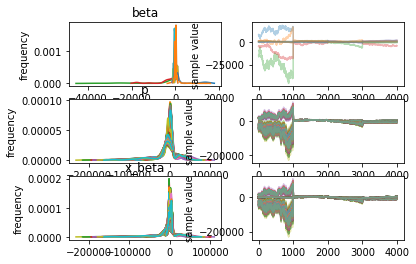

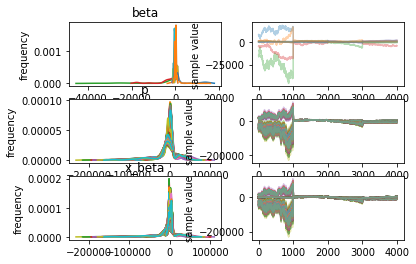

In [ ]:
print (fit)
fit.plot()

Inference for Stan model: anon_model_58ecac55efcb21c757496a8cdf4ab6db.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[1,1]     611.73  618.13 923.28 -398.4  27.68 201.35 921.87 2590.2      2    3.9
beta[2,1]     1032.7  242.79 950.37 -513.8 422.41 1068.6 1408.2 3721.7     15   1.29
beta[3,1]      -1537  845.67 1365.3  -4522  -1917  -1075 -595.2   65.6      3   3.43
beta[4,1]     -634.7   619.4 2169.2  -7216  -1124 -43.01 580.29 2323.7     12   1.36
beta[1,2]      131.3  324.43 507.05 -542.5 -300.4   35.4 371.84 1129.8      2   3.18
beta[2,2]     140.99  148.09 417.67 -434.3 -109.8  71.62  304.9 1341.6      8   1.84
beta[3,2]     264.52  307.01 469.16 -283.1 -98.88 155.77 418.58 1393.9      2   3.87
beta[4,2]      -7.81   79.49 214.97 -680.8 -20.38   53.2  91.01 403.21      7   1.66
beta[1,3]     122.91  324.39  507.0 -552.1 -30

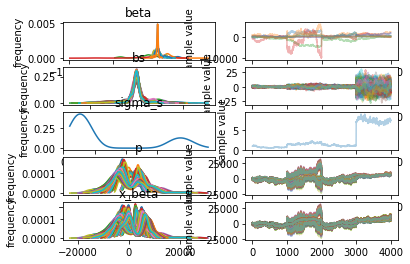

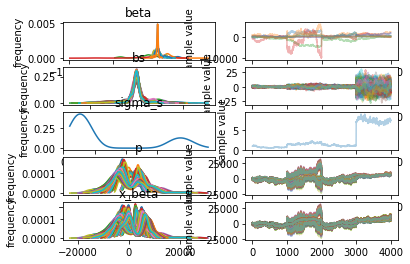

In [ ]:
print (fit2)
fit2.plot()

In [ ]:
names = fit.model_pars
print (names)

['beta', 'p', 'x_beta']


In [ ]:
names2 = fit2.model_pars
print (names2)

['beta', 'bs', 'sigma_s', 'p', 'x_beta']


In [ ]:
beta1,beta2,beta3,beta4 = np.mean(fit['beta'][:,0]),np.mean(fit['beta'][:,1]),np.mean(fit['beta'][:,2]),np.mean(fit['beta'][:,3])

print (beta1,beta2,beta3,beta4)

1210.3455071468993 67.32261463633047 -2344.3760762400184 -1345.3023731678172


In [ ]:
beta1,beta2,beta3,beta4 = np.mean(fit2['beta'][:,0]),np.mean(fit2['beta'][:,1]),np.mean(fit2['beta'][:,2]),np.mean(fit2['beta'][:,3])
print (beta1,beta2,beta3,beta4)

sigma_s= np.mean(fit2['sigma_s'])
print (sigma_s)

288.6453756385685 435.37941764631114 -332.4880163488936 -212.36120380049417
2.7147087159065832


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


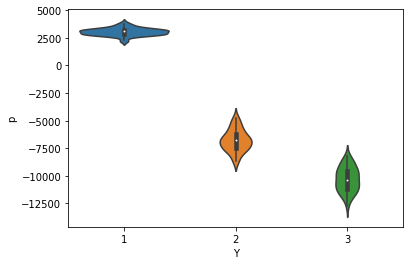

In [ ]:
p = fit['p'].T
p_median = []
for i in range(len(y)):
    p_median.append(np.median(p[i]))

plot_df = pd.DataFrame({
    'Y': y,
    'p': p_median
})
sns.violinplot(x='Y', y='p', data=plot_df)
plt.show()

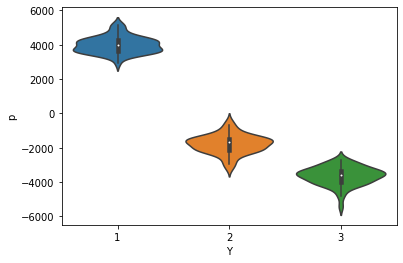

In [ ]:
p = fit2['p'].T
p_median = []
for i in range(len(y)):
    p_median.append(np.median(p[i]))

plot_df = pd.DataFrame({
    'Y': y,
    'p': p_median
})
sns.violinplot(x='Y', y='p', data=plot_df)
plt.show()